In [6]:
import numpy as np
import pandas as pd
import sklearn.linear_model
import sklearn.metrics
import os
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
# install with conda install -c pytorch pytorch
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
# install with conda install -c conda-forge transformers  
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [81]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-v0_8') # pretty matplotlib plots


## Load Data

In [82]:
data_dir = 'data_reviews'
x_train_df = pd.read_csv(os.path.join(data_dir, 'x_train.csv'))
y_train_df = pd.read_csv(os.path.join(data_dir, 'y_train.csv'))

N, n_cols = x_train_df.shape
# print("Shape of x_train_df: (%d, %d)" % (N,n_cols))
# print("Shape of y_train_df: %s" % str(y_train_df.shape))
# x_train_df

In [83]:
# # df to list
tr_text_list = x_train_df['text'].values.tolist()

In [84]:
y_train_list = y_train_df['is_positive_sentiment'].values.tolist()


## Partition sentences into words

In [85]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [86]:
# vectorizer = CountVectorizer()

In [87]:
# adv_vectorizer = TfidfVectorizer(ngram_range = (1, 2), min_df = 0.001) # considering bigrams, ignore rare words

### How big is my vocabulary?

In [88]:
# x = adv_vectorizer.fit_transform(tr_text_list)
# vocab = adv_vectorizer.get_feature_names_out()
# vocab.size

In [89]:
# x_train_NV = x.toarray()
# x_train_NV.shape
# # N is the number of sentences, and V is the number of vocabulary

In [90]:
# N = x_train_NV.shape[0]
# V = x_train_NV.shape[1]

### Get the common and rare

In [91]:
# x_common = []

# x_col_sum = np.sum(x_train_NV, axis = 0)

# np.max(x_col_sum)

In [92]:
# x_col_sum.shape, x_col_sum[2701]

In [93]:
# x_common = x_col_sum > N/1.5 # happens half of the time 
# x_common_V = [int(x) for x in x_common]
# x_common_V = np.array(x_common_V)

In [94]:
# x_rare = x_col_sum < 10
# x_rare_V = [int(x) for x in x_rare]
# x_rare_V = np.array(x_rare_V)

In [95]:
# x_common_V.reshape(V, 1)

In [96]:
# x_common = x_train_NV * x_common_V 
# x_rare = x_train_NV * x_rare_V

### Get Normal Vocab

In [97]:
# # x_normal = x_train_NV * (1 - x_common_V) * (1 - x_rare_V)
# x_normal = x_train_NV

In [98]:
# y_train_list = np.array(y_train_list)

In [99]:
%run performance_metrics.py
%run cross_validation.py

<Figure size 800x550 with 0 Axes>

In [100]:
# M = 2

# x_tr_M2 = np.random.randint(2, size=10).reshape(-1, 1)
# x_va_N2 = np.random.randint(2, size=10).reshape(-1, 1)
# y_tr_M = np.random.randint(2, size=10)
# y_va_N = np.random.randint(2, size=10)

## Cross Validation

In [101]:
%run binary_metrics.py
%run proba_metrics.py

In [102]:
# K = 5 # num folds of CV
# random_state = 1234

# train_error_per_fold = np.zeros(K, dtype=np.float32)
# test_error_per_fold = np.zeros(K, dtype=np.float32)

# N = x_normal.shape[0]
# # TODO define the folds here by calling your function
# # e.g. ... = make_train_and_test_row_ids_for_n_fold_cv(...)
# train_ids, test_ids = make_train_and_test_row_ids_for_n_fold_cv(
#     N, K, random_state)

# len(train_ids[0]), len(test_ids[0])

In [103]:
# y_list = y_train_list

## normalize the data

In [104]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [149]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
            outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output
            x = self.dropout(pooled_output)
            logits = self.fc(x)
            return logits

In [150]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [151]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [152]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        return "positive" if preds.item() == 1 else "negative"

In [153]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 100
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

In [154]:
train_texts, val_texts, train_labels, val_labels = train_test_split(tr_text_list, y_train_list, test_size=0.2, random_state=42)

In [155]:
train_labels

array([0, 0, 0, ..., 0, 1, 0])

In [156]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [157]:
for batch in train_dataset:
    input_ids = batch['input_ids'].to(device)
    print(input_ids)

tensor([ 101, 2673, 2055, 2023, 4031, 2003, 3308, 1012, 2034,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
tensor([  101,  2065,  2045,  2003,  1037,  3612,  1010,  2009,  2003,  3294,
        11809,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0, 

In [158]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

In [159]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/Users/siarasmall/opt/anaconda3/envs/cs135_env/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [160]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    train(model, train_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluate(model, val_dataloader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)

Epoch 1/4
Validation Accuracy: 0.9458
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       237
           1       0.95      0.94      0.95       243

    accuracy                           0.95       480
   macro avg       0.95      0.95      0.95       480
weighted avg       0.95      0.95      0.95       480

Epoch 2/4
Validation Accuracy: 0.9500
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       237
           1       0.98      0.92      0.95       243

    accuracy                           0.95       480
   macro avg       0.95      0.95      0.95       480
weighted avg       0.95      0.95      0.95       480

Epoch 3/4


In [ ]:
# C_grid = np.logspace(-4, 5, 15)

In [ ]:
# cv_tr_bce_list = list()
# cv_va_bce_list = list()
# cv_te_bce_list = list()



# cv_va_auroc_list = list()
# cv_tr_auroc_list = list()
# va_mean_cv_auroc_list = list()
# tr_mean_cv_auroc_list = list()

# model_list = list()
# tr_bce_list_for_each_C = list()
# va_bce_list_for_each_C = list()
# # idx = 0
# for C in C_grid:

#     model_F3_list = list()

#     # Allocate lists for storing BCE metrics
#     tr_bce_list = list()
#     va_bce_list = list()
#     te_bce_list = list()
    
#     tr_auroc_list = list()
#     va_auroc_list = list()

#     # idx = idx + 1
#     for i in range(K):
#         xtr = x_tr[i]
#         ytr = y_tr[i]
#         xva = x_va[i]
#         yva = y_va[i]

#         lr_F3 = sklearn.linear_model.LogisticRegression(C = C, penalty = 'l2', solver='lbfgs', max_iter=2000) # TODO fixme
#         lr_F3.fit(xtr, ytr) # TODO fixme

#         model_F3_list.append(lr_F3)

#         yproba1_tr_M = lr_F3.predict_proba(xtr)[:,1] # The probability of predicting class 1 on the training set
#         yproba1_va_N = lr_F3.predict_proba(xva)[:,1] # The probability of predicting class 1 on the validation set
        
        
#         # get auroc score 
#         va_auroc = roc_auc_score(ytr, yproba1_tr_M)
#         va_auroc = roc_auc_score(yva, yproba1_va_N)
#         tr_auroc_list.append(va_auroc)
#         va_auroc_list.append(va_auroc)
        
#         my_tr_bce = calc_mean_binary_cross_entropy_from_probas(ytr, yproba1_tr_M) # TODO fixme
#         my_va_bce = calc_mean_binary_cross_entropy_from_probas(yva, yproba1_va_N) # TODO fixme
#         # Save bce for future selection on Models.
#         tr_bce_list.append(my_tr_bce) 
#         va_bce_list.append(my_va_bce)
    
    
#     va_mean_cv_auroc = sum(va_auroc_list) / len(va_auroc_list)
#     va_mean_cv_auroc_list.append(va_mean_cv_auroc)
    
#     cv_va_auroc_list.append(va_auroc_list)
    
#     tr_mean_cv_auroc = sum(tr_auroc_list) / len(tr_auroc_list)
#     tr_mean_cv_auroc_list.append(tr_mean_cv_auroc)
    
#     cv_tr_auroc_list.append(tr_auroc_list)
    
    
#     tr_bce_list_for_each_C.append(tr_bce_list)
#     va_bce_list_for_each_C.append(va_bce_list)
    
#     model_list.append(model_F3_list)
    
    
    
    
    
#     cv_tr_bce_list.append((sum(tr_bce_list)/len(tr_bce_list)))
#     cv_va_bce_list.append((sum(va_bce_list)/len(va_bce_list)))

In [ ]:
# best_C_index = np.argmax(va_mean_cv_auroc_list)
# best_C_index

7

In [ ]:
# best_fold_in_C = np.argmax(cv_va_auroc_list[best_C_index])

In [ ]:
# best_C__lr = C_grid[best_C_index]
# best_lr = model_list[best_C_index][best_fold_in_C]

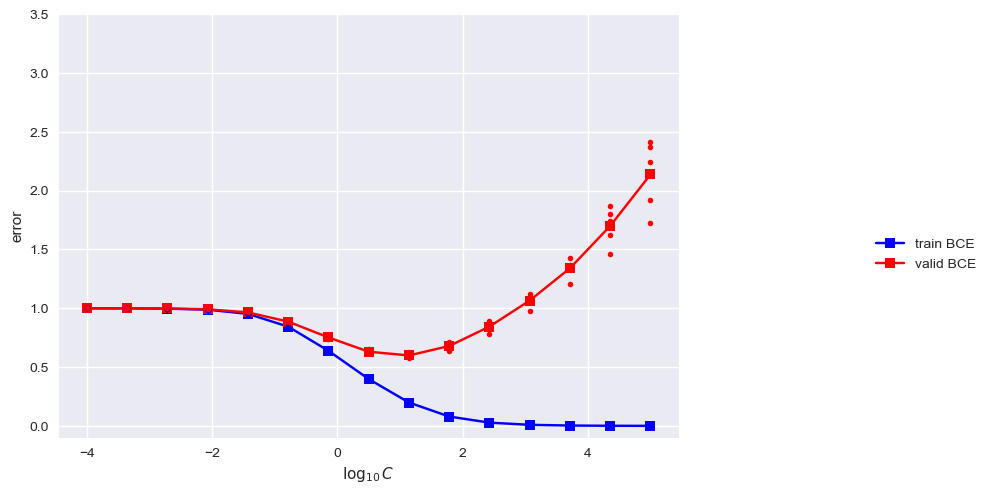

In [ ]:
# plt.plot(np.log10(C_grid), cv_tr_bce_list, 'bs-', label='train BCE')
# plt.plot(np.log10(C_grid), cv_va_bce_list, 'rs-', label='valid BCE')

# # for j in range(len(hl_size_grid)):
# #     plt.plot(hl_size_grid[j][0] *hl_size_grid[j][1] , cv_tr_bce_list[j], 'bs-', label='train BCE')
# #     plt.plot(hl_size_grid[j][0] *hl_size_grid[j][1], cv_va_bce_list[j], 'rs-', label='valid BCE')


# for i in range(len(tr_bce_list_for_each_C)):
#     for j in range(len(tr_bce_list_for_each_C[0])):
#         plt.plot(np.log10(C_grid[i]), tr_bce_list_for_each_C[i][j], marker='o', color='blue', markersize = 4)
#         plt.plot(np.log10(C_grid[i]), va_bce_list_for_each_C[i][j], marker='o', color='red', markersize = 4)
        
# plt.ylabel('error')
# plt.xlabel("$\log_{10} C$");
# plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
# plt.ylim([-0.1, 3.5]);

In [ ]:
# print("Best model has coefficient values:")
# print(best_lr.coef_)

In [ ]:
# prng = np.random.RandomState(101)

# bestlr_yproba1_tr = best_lr.predict_proba(x_tr[best_fold_in_C])[:,1] # TODO fixme
# bestlr_yproba1_va = best_lr.predict_proba(x_va[best_fold_in_C])[:,1] # TODO fixme

In [ ]:
# bestlr_yproba1_va.shape
# y_va[best_fold_in_C].shape

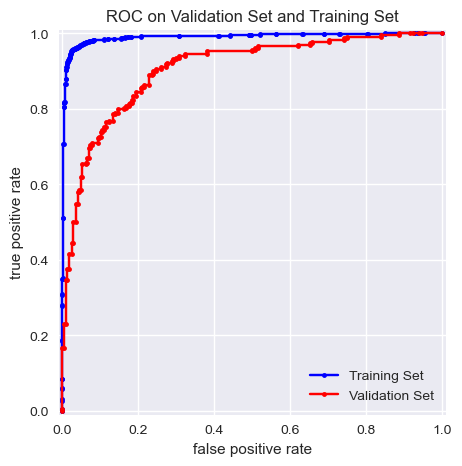

In [ ]:
# # Follow the instruction of HW2 and produce Figure 1 for your report:
# plt.subplots(nrows=1, ncols=1, figsize=(5,5));

# # TODO Use provided data and predictions on the Validation set
# # Produce the ROC Curve utilizing `sklearn.metrics.roc_curve' within plt defined above.
# # To start, read the official Document and examples of 'sklearn.metrics.roc_curve'. 
# va_fpr, va_tpr, va_thresholds = sklearn.metrics.roc_curve(y_va[best_fold_in_C], bestlr_yproba1_va)
# tr_fpr, tr_tpr, tr_thresholds = sklearn.metrics.roc_curve(y_tr[best_fold_in_C], bestlr_yproba1_tr)

# # Read HW2 instructions carefully for plot style (line type, line color, etc.)

# plt.plot(tr_fpr, tr_tpr, 'b.-', label = "Training Set" )
# plt.plot(va_fpr, va_tpr, 'r.-', label = "Validation Set" )
# plt.title("ROC on Validation Set and Training Set");
# plt.xlabel('false positive rate');
# plt.ylabel('true positive rate');
# plt.legend(loc='lower right');
# B = 0.01
# plt.xlim([0 - B, 1 + B]);
# plt.ylim([0 - B, 1 + B]);

## Confusion Matrix on the best C/fold

In [ ]:
# import threshold_selection
# from confusion_matrix import calc_confusion_matrix_for_probas_and_threshold

In [ ]:
# best_thr_default = 0.5

# print(sklearn.metrics.confusion_matrix(y_va[best_fold_in_C], bestlr_yproba1_va >= best_thr_default))

# thresh_grid, perf_dict = threshold_selection.compute_perf_metrics_across_thresholds(y_va[best_fold_in_C], bestlr_yproba1_va, [best_thr_default])

# tpr = perf_dict['tpr'][0]# TODO fixme
# ppv = perf_dict['ppv'][0] # TODO fixme

# print(f"chosen thr = {best_thr_default :.4f}, tpr = {tpr :.4f}, ppv = {ppv :.4f},")

[[214  33]
 [ 54 180]]
chosen thr = 0.5000, tpr = 0.7692, ppv = 0.8451,


## Area Under ROC Curve

In [ ]:
# roc_auc_score(y_va[best_fold_in_C],bestlr_yproba1_va)

0.9067787812727084

## read the test file into vocab matrix

In [ ]:
# x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
# x_test_df.shape

(600, 2)

In [ ]:
# te_text_list = x_test_df['text'].values.tolist()
# len(te_text_list)

600

In [ ]:
# vec = CountVectorizer(vocabulary = vocab)
# t = vec.fit_transform(te_text_list)
# t

<600x2368 sparse matrix of type '<class 'numpy.int64'>'
	with 4994 stored elements in Compressed Sparse Row format>

In [ ]:
# te_array = t.toarray()
# te_array.shape

(600, 2368)

In [ ]:
# y_te_proba = best_lr.predict_proba(te_array)[:,1]
# y_te_proba

array([6.03115103e-01, 9.42553862e-01, 3.87374501e-04, 4.31111555e-03,
       4.32422603e-01, 6.44922715e-04, 5.66271010e-03, 1.94831076e-01,
       2.07691226e-01, 5.03907386e-01, 2.81172409e-02, 1.79054863e-01,
       1.21112046e-02, 8.64231441e-03, 4.98882659e-02, 1.68034833e-03,
       1.16007275e-03, 1.48432308e-01, 2.09821614e-01, 8.40793472e-01,
       5.05246241e-01, 4.87653173e-01, 1.22960837e-01, 1.26861087e-01,
       6.47335878e-01, 7.65127767e-02, 2.55947822e-01, 5.54907659e-01,
       7.64187219e-02, 6.36761166e-04, 6.11814767e-01, 1.52226593e-01,
       8.32021304e-01, 7.46485070e-05, 7.87548776e-01, 8.06194813e-01,
       3.69460296e-02, 8.20124657e-03, 2.67162597e-01, 6.73127046e-01,
       3.03718798e-02, 1.69739140e-02, 9.15423381e-01, 1.34877946e-01,
       3.46291908e-03, 8.01432748e-04, 2.22612914e-02, 1.21486056e-02,
       2.01810672e-03, 7.64187219e-02, 7.47173171e-02, 1.42609807e-01,
       9.87468192e-01, 8.45460538e-02, 1.84934512e-01, 2.75675321e-01,
      